# UNet Optimization

**Note:** In this notebook we can experiment with 

- Supervised vs Unsupervised
- UNet Small vs UNet Medium vs ResUNet
- Custom Loss Functions
- Epochs and Learning Rate
- Different Targets (Gabor vs Grayscale)
- Adding different types of noise

**Note:** The images displayed is of authors own collected fingerprint and hence is released here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_msssim import ssim
from skimage.morphology import skeletonize
import random

# Dataset

In [2]:
def add_patch_blur(img, num_patches=20, max_size=80, ksize=15):
    img_np = (img.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
    h, w, _ = img_np.shape
    
    for _ in range(num_patches):
        ph, pw = np.random.randint(20, max_size, size=2)
        x = np.random.randint(0, w - pw)
        y = np.random.randint(0, h - ph)
        
        patch = img_np[y:y+ph, x:x+pw]
        patch_blur = cv2.GaussianBlur(patch, (ksize, ksize), 0)
        img_np[y:y+ph, x:x+pw] = patch_blur
    
    img_out = torch.from_numpy(img_np.astype(np.float32) / 255.0).permute(2,0,1)
    return img_out

In [3]:
def pad_and_resize(img: Image.Image, size=512):
    """Pad to square with black padding, then resize to (size,size)."""
    w, h = img.size
    pad_left = pad_right = pad_top = pad_bottom = 0

    if w > h:
        diff = w - h
        pad_top = diff // 2
        pad_bottom = diff - pad_top
    else:
        diff = h - w
        pad_left = diff // 2
        pad_right = diff - pad_left

    img_padded = TF.pad(img, padding=(pad_left, pad_top, pad_right, pad_bottom), padding_mode="constant", fill=0)

    img_resized = TF.resize(img_padded, (size, size))

    pad_info = {
        "orig_size": (h, w),
        "pad": (pad_top, pad_bottom, pad_left, pad_right),
        "resized_size": (size, size),
    }

    return img_resized, pad_info

def create_valid_mask(pad_info, size=512):
    """Create binary mask (1 = valid/original area, 0 = padding)."""
    h, w = pad_info["orig_size"]
    top, bottom, left, right = pad_info["pad"]

    mask = np.zeros((h + top + bottom, w + left + right), dtype=np.uint8)
    mask[top:top+h, left:left+w] = 1

    mask_resized = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    return torch.tensor(mask_resized, dtype=torch.float32)

class PadResizeToTensor:
    def __init__(self, size=512):
        self.size = size

    def __call__(self, img):
        img_resized, pad_info = pad_and_resize(img, self.size)
        mask = create_valid_mask(pad_info, self.size)
        mask = mask.unsqueeze(0) 
        return TF.to_tensor(img_resized), mask, pad_info

def undo_pad_and_resize(output, pad_info, mask=None):
    """
    Reverts network output (size×size) back to original image size
    using the valid mask from pad_and_resize.
    """
    if isinstance(output, torch.Tensor):
        output = output.detach().cpu().numpy()
        if output.ndim == 3 and output.shape[0] in [1, 3]:
            output = np.transpose(output, (1, 2, 0))

    h, w = pad_info["orig_size"]
    top, bottom, left, right = pad_info["pad"]
    padded_h, padded_w = h + top + bottom, w + left + right

    output_resized = cv2.resize(output, (padded_w, padded_h), interpolation=cv2.INTER_CUBIC)

    if mask is None:
        mask = np.zeros((padded_h, padded_w), dtype=np.uint8)
        mask[top:top+h, left:left+w] = 1
    elif isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    ys, xs = np.where(mask > 0)
    y1, y2 = ys.min(), ys.max() + 1
    x1, x2 = xs.min(), xs.max() + 1
    output_cropped = output_resized[y1:y2, x1:x2]

    output_final = cv2.resize(output_cropped, (w, h), interpolation=cv2.INTER_CUBIC)

    return output_final


In [ ]:
class FingerprintDataset(Dataset):
    def __init__(self, fnf_dir, flash_gray_dir, gab_ref, transform=None, augment_fn=None):
        self.fnf_files = sorted(glob.glob(os.path.join(fnf_dir, "*.tif")))
        self.flash_files = sorted(glob.glob(os.path.join(flash_gray_dir, "*.tif")))
        self.gab_files = sorted(glob.glob(os.path.join(gab_ref, "*.tif")))
        self.transform = transform
        self.augment_fn = augment_fn  # new

    def __len__(self):
        return len(self.fnf_files)

    def __getitem__(self, idx):
        fnf_img = Image.open(self.fnf_files[idx]).convert("RGB")   # FNF RGB
        flash_img = Image.open(self.flash_files[idx]).convert("L") # Flash grayscale
        gab_img = Image.open(self.gab_files[idx]).convert("L")     # Gabor reference grayscale

        if self.transform:
            fnf_img, fnf_mask, fnf_pad_info = self.transform(fnf_img)
            flash_img, flash_mask, flash_pad_info = self.transform(flash_img)
            gab_img, gab_mask, gab_pad_info = self.transform(gab_img)
        else:
            fnf_img = TF.to_tensor(fnf_img)
            flash_img = TF.to_tensor(flash_img)
            gab_img = TF.to_tensor(gab_img)
            h, w = fnf_img.shape[1], fnf_img.shape[2]
            fnf_mask = torch.ones((1, h, w), dtype=torch.float32)
            flash_mask = torch.ones((1, h, w), dtype=torch.float32)
            gab_mask = torch.ones((1, h, w), dtype=torch.float32)
            fnf_pad_info, flash_pad_info, gab_pad_info = None, None, None

        # Apply noise only on fnf_img
        if self.augment_fn is not None:
            fnf_img = self.augment_fn(fnf_img)

        return fnf_img, flash_img, gab_img, fnf_mask, flash_mask, gab_mask, fnf_pad_info, flash_pad_info, gab_pad_info

fnf_dir = "<DATASET>"
flash_gray_dir = "<DATASET>"
gab_ref = "<DATASET>"

transform = PadResizeToTensor(size=512)

full_dataset = FingerprintDataset(fnf_dir, flash_gray_dir, gab_ref, transform=transform, augment_fn=add_patch_blur)

# Split into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset = Subset(full_dataset, range(0, train_size))
val_dataset   = Subset(full_dataset, range(train_size, train_size + val_size))
test_dataset  = Subset(full_dataset, range(train_size + val_size, len(full_dataset)))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# U-Net Small

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(3, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = DoubleConv(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = DoubleConv(64, 32)

        self.final = nn.Conv2d(32, 1, 1) # Output grayscale
        self.act = nn.Sigmoid()

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        m = self.middle(p2)

        u2 = self.up2(m)
        c2_cat = torch.cat([u2, c2], dim=1)
        c2_out = self.conv2(c2_cat)
        u1 = self.up1(c2_out)
        c1_cat = torch.cat([u1, c1], dim=1)
        c1_out = self.conv1(c1_cat)

        return self.act(self.final(c1_out))

# U-Net Medium - for experiments

In [8]:
class UNetMedium(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.middle = DoubleConv(256, 512)
        self.dropout = nn.Dropout2d(0.3)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        # Final output
        self.final = nn.Conv2d(64, 1, 1)  
        self.act = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        c1 = self.down1(x)
        p1 = self.pool1(c1)
        c2 = self.down2(p1)
        p2 = self.pool2(c2)
        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        # Bottleneck
        m = self.middle(p3)
        m = self.dropout(m)

        # Decoder
        u3 = self.up3(m)
        c3_cat = torch.cat([u3, c3], dim=1)
        c3_out = self.conv3(c3_cat)

        u2 = self.up2(c3_out)
        c2_cat = torch.cat([u2, c2], dim=1)
        c2_out = self.conv2(c2_cat)

        u1 = self.up1(c2_out)
        c1_cat = torch.cat([u1, c1], dim=1)
        c1_out = self.conv1(c1_cat)

        return self.act(self.final(c1_out))

# U-ResNet - for experiments

In [9]:
class ResidualDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout)
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = self.residual(x)
        out = self.conv(x)
        out = self.dropout(out)
        out += residual
        return self.relu(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return x * self.sigmoid(out)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2, use_attention=True):
        super().__init__()
        self.conv = ResidualDoubleConv(in_channels, out_channels, dropout=dropout)
        self.pool = nn.MaxPool2d(2)
        self.attention = SpatialAttention() if use_attention else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.attention(x)
        skip = x
        x = self.pool(x)
        return x, skip

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.2, use_attention=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ResidualDoubleConv(in_channels, out_channels, dropout=dropout)
        self.attention = SpatialAttention() if use_attention else nn.Identity()

    def forward(self, x, skip):
        x = self.up(x)
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return self.attention(x)

class UNetResSmall(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, dropout=0.2, use_attention=True):
        super().__init__()
        self.inc = ResidualDoubleConv(in_channels, 32, dropout=dropout)

        self.down1 = Down(32, 64, dropout=dropout, use_attention=use_attention)
        self.down2 = Down(64, 128, dropout=dropout, use_attention=use_attention)

        self.mid = ResidualDoubleConv(128, 256, dropout=dropout)

        self.up2 = Up(256, 128, dropout=dropout, use_attention=use_attention)
        self.up1 = Up(128, 64, dropout=dropout, use_attention=use_attention)

        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2, skip1 = self.down1(x1)
        x3, skip2 = self.down2(x2)

        mid = self.mid(x3)

        x = self.up2(mid, skip2)
        x = self.up1(x, skip1)
        return self.outc(x)

# Custom Loss

In [10]:
class GaborRidgeLoss(nn.Module):
    def __init__(self, ridge_weight=3.0, valley_weight=1.0):
        super().__init__()
        self.ridge_weight = ridge_weight
        self.valley_weight = valley_weight

    def forward(self, pred_gray, gabor_ref, valid_mask=None):
        """
        pred_gray: (B,1,H,W) predicted grayscale (0-1)
        gabor_ref: (B,1,H,W) gabor binarized reference (0= ridge, 1= valley)
        """
        weights = torch.where(gabor_ref < 0.5,
                              torch.full_like(gabor_ref, self.ridge_weight),
                              torch.full_like(gabor_ref, self.valley_weight))
        
        loss_map = F.l1_loss(pred_gray, gabor_ref, reduction="none") * weights

        if valid_mask is not None:
            loss_map = loss_map * valid_mask

        return loss_map.mean()


In [11]:
# Edge loss (Sobel)
def sobel_edge(tensor):
    sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=tensor.device).view(1,1,3,3)
    sobel_y = sobel_x.transpose(2,3)
    ex = F.conv2d(tensor, sobel_x, padding=1)
    ey = F.conv2d(tensor, sobel_y, padding=1)
    return torch.sqrt(ex**2 + ey**2 + 1e-8)

def edge_loss(pred, target):
    pe = sobel_edge(pred)
    te = sobel_edge(target)
    return F.l1_loss(pe, te)

In [12]:
class AdaptiveLocalContrastLoss(nn.Module):
    def __init__(self, block_size=16, base_weights=(0.5, 0.3, 0.2)):
        """
        base_weights: tuple in BGR order (Blue, Green, Red)
        """
        super().__init__()
        self.block_size = block_size
        self.base_weights = torch.tensor(base_weights).float()

    def forward(self, fnf_rgb, pred_gray, target_gray, valid_mask=None):
        """
        fnf_rgb: (B, 3, H, W) RGB image (float 0-1)
        pred_gray, target_gray: (B, 1, H, W) grayscale images
        valid_mask: (B, 1, H, W) mask (1 = valid, 0 = padding)
        """
        B = fnf_rgb.shape[0]

        patch_means = self._patch_mean(fnf_rgb)  
        patch_sum = patch_means.sum(dim=2, keepdim=True) + 1e-6
        patch_ratios = patch_means / patch_sum

        bgr_to_rgb_idx = [2, 1, 0]
        adaptive_weights = torch.stack([
            self.base_weights[i] * patch_ratios[:, :, bgr_to_rgb_idx[i]] 
            for i in range(3)
        ], dim=2)
        adaptive_weights = adaptive_weights / (adaptive_weights.sum(dim=2, keepdim=True) + 1e-6)

        pred_std = self._local_std(pred_gray.squeeze(1))     

        if valid_mask is not None:

            vm = valid_mask.squeeze(1) 
            vm_unfold = vm.unfold(1, self.block_size, self.block_size) \
                         .unfold(2, self.block_size, self.block_size)  
            vm_unfold = vm_unfold.contiguous().view(B, -1, self.block_size * self.block_size).float()
            patch_valid = (vm_unfold.mean(dim=2) > 0.5).float() 

            pred_std = pred_std * patch_valid
        reward = (pred_std * adaptive_weights.sum(dim=2)).sum() / (pred_std.numel() + 1e-6)

        return reward

    def _patch_mean(self, img):
        B, C, H, W = img.shape
        patches = img.unfold(2, self.block_size, self.block_size) \
                     .unfold(3, self.block_size, self.block_size) 
        patches = patches.contiguous().view(B, C, -1, self.block_size * self.block_size)
        patch_means = patches.mean(dim=3)  
        return patch_means.permute(0, 2, 1) 

    def _local_std(self, img):
        B, H, W = img.shape
        patches = img.unfold(1, self.block_size, self.block_size) \
                     .unfold(2, self.block_size, self.block_size)  
        patches = patches.contiguous().view(B, -1, self.block_size * self.block_size)
        stds = patches.std(dim=2)  
        return stds

In [13]:
l1_loss_fn = nn.L1Loss(reduction="none") 
contrast_loss_fn = AdaptiveLocalContrastLoss(block_size=16, base_weights=(0.5, 0.4, 0.1))
gabor_loss_fn = GaborRidgeLoss(ridge_weight=2.0, valley_weight=1.0)

def combined_loss(fnf_rgb, pred_gray, target_gray, valid_mask, gabor_ref, alpha=0.4, beta=0.2, gamma=0.3, delta=0.1, eta=0.1):
    loss_l1_map = l1_loss_fn(pred_gray, target_gray)
    loss_l1 = (loss_l1_map * valid_mask).sum() / (valid_mask.sum() + 1e-6)
    loss_contrast = contrast_loss_fn(fnf_rgb, pred_gray, target_gray, valid_mask=valid_mask)
    ssim_map = ssim(pred_gray, target_gray, data_range=1.0, size_average=False)
    loss_ssim = (1 - ssim_map).mean()
    sobel_loss = edge_loss(pred_gray, target_gray)
    loss_gabor = gabor_loss_fn(pred_gray, gabor_ref, valid_mask)

    return alpha * loss_l1 - beta * loss_contrast + gamma * loss_ssim  + delta * loss_gabor + eta * sobel_loss

## Train

In [14]:
device = torch.device("mps") # replace with cuda or mps or cpu
model = UNetSmall().to(device) # replace with model we want to train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 30
train_losses = []
val_losses = []
save_model_path = "model.pth" # can modify

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for fnf_rgb, flash_gray, gab_img, fnf_mask, flash_mask, gab_mask, fnf_pad_info, flash_pad_info, gab_pad_info in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        fnf_rgb = fnf_rgb.to(device)             
        flash_gray = flash_gray.to(device)       
        fnf_mask = fnf_mask.to(device)           
        gab_img = gab_img.to(device)             
        optimizer.zero_grad()
        output = model(fnf_rgb)                  

        loss = combined_loss(fnf_rgb, output, flash_gray, fnf_mask, gab_img)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for fnf_rgb, flash_gray, gab_img, fnf_mask, flash_mask, gab_mask, fnf_pad_info, flash_pad_info, gab_pad_info in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            fnf_rgb = fnf_rgb.to(device)
            flash_gray = flash_gray.to(device)
            fnf_mask = fnf_mask.to(device)
            gab_img = gab_img.to(device)
            output = model(fnf_rgb)

            loss = combined_loss(fnf_rgb, output, flash_gray, fnf_mask, gab_img)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss/len(train_loader):.4f} "
          f"Val Loss: {val_loss/len(val_loader):.4f}")
    
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

torch.save(model.state_dict(), save_model_path)

# Test

**Note:** We can use these functions to test our result

In [ ]:
def local_contrast(image, block_size=16):
    h, w = image.shape
    stds = []
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i+block_size, j:j+block_size]
            if block.size > 0:
                stds.append(np.std(block))
    return np.mean(stds)

def run_inference_on_index(model, dataset, index, device):
    model.eval()
    fnf_img, flash_img, gab_img, fnf_mask, flash_mask, gab_mask, fnf_pad_info, flash_pad_info, gab_pad_info = dataset[index]

    fnf_img_batch = fnf_img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(fnf_img_batch)           
        output_np = output.squeeze().cpu().numpy() 

    fnf_img_np = fnf_img.permute(1, 2, 0).cpu().numpy()  
    flash_img_np = flash_img.squeeze(0).cpu().numpy()    
    gab_img_np = gab_img.squeeze(0).cpu().numpy()

    fnf_restored = undo_pad_and_resize(fnf_img_np, fnf_pad_info) 
    flash_restored = undo_pad_and_resize(flash_img_np, flash_pad_info)  
    gab_restored = undo_pad_and_resize(gab_img_np, gab_pad_info)

    output_restored = undo_pad_and_resize(output_np, fnf_pad_info)  

    return fnf_img_np, flash_img_np, output_np, gab_img_np, fnf_restored, flash_restored, output_restored, gab_restored

def show_sample(fnf_img, flash_img, output_img, gab_img):

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title(f"Input")
    plt.imshow(fnf_img)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title(f"Flash Grayscale Target")
    plt.imshow(flash_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title(f"Flash Gabor Target")
    plt.imshow(gab_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title(f"Output")
    plt.imshow(output_img, cmap='gray')
    plt.axis('off')
    plt.show()


In [ ]:
model.load_state_dict(torch.load(save_model_path))
model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.033205416..1.0610073].


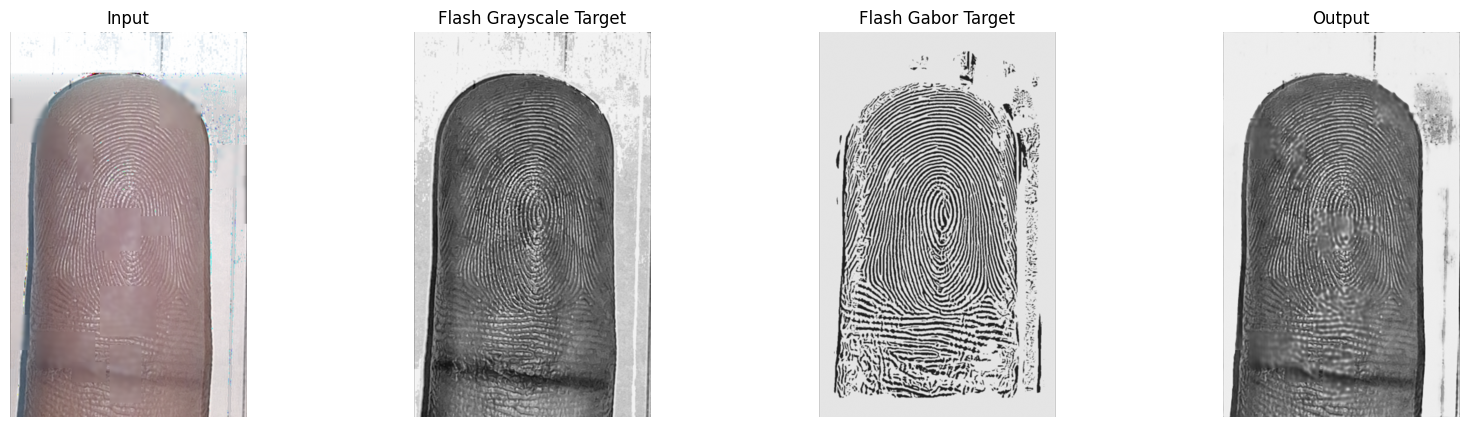

In [69]:
sample_index = 22
fnf_img_np, flash_img_np, output_np, gab_np, fnf_restored, flash_restored, output_restored, gab_restored = run_inference_on_index(
   model, test_loader.dataset, sample_index, device
)

show_sample(
    fnf_restored, flash_restored, output_restored, gab_restored)

In [15]:
def fingerprint_quality_metrics(img, patch_size=16):
    """
    Compute fingerprint quality metrics:
    1. Local contrast
    2. Minutiae count
    3. Orientation coherence
    4. Sharpness
    """
    if isinstance(img, torch.Tensor):
        img = img.squeeze().detach().cpu().numpy()
    if img.dtype != np.uint8:
        img = (img * 255).clip(0, 255).astype(np.uint8)

    h, w = img.shape

    # 1. Local contrast
    local_contrast = np.mean([
        img[i:i+patch_size, j:j+patch_size].std()
        for i in range(0, h, patch_size)
        for j in range(0, w, patch_size)
    ])

    # 2. Sharpness
    sharpness = cv2.Laplacian(img, cv2.CV_64F).var()


    # 3. Edge Clarity
    edges = cv2.Canny(img, 100, 200)  
    edge_clarity = np.sum(edges > 0) / edges.size

    return {
        "local_contrast": float(local_contrast),
        "sharpness": float(sharpness),
        "edge_clarity": float(edge_clarity)
    }
